In [1]:
import warnings; warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import yfinance as yf

import contextlib
import io
import matplotlib.pyplot as plt
import math
import importlib

import sys, os

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [2]:

from rough_functions import * 
from new_functions import * 

In [3]:
stock_info = pd.read_csv('stock_info.csv').set_index('symbol')
committee_assignments = pd.read_csv("committees.csv", usecols=['gender', 'year', 'name', 'committees'])

If needed, pull data

In [4]:
data = freshData()

Otherwise, you can read data from saved csv formatted files

In [5]:
data = readData()

data=data.drop(data[data['ticker'].isna()].index, axis=0)
print("Num. Obs. = "+str(len(data)))
print("Earliest Obs. = "+str(min(data['transaction_date'])))
print("Latest Obs. = "+str(max(data['transaction_date'])))


Num. Obs. = 23840
Earliest Obs. = 2012-06-19 00:00:00
Latest Obs. = 2022-12-31 00:00:00


Note that for this experiment the dataset will be static and include all filled reports from 2012 throught the end of 2022.

In [6]:
data.head()

,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,party,state,...,dates_diff,dateMS,percentVsSnP,amountL,amountM,amountH,snp500,last_name,district,cap_gains_over_200_usd
0,2022-12-28,Self,RNWK,"RealNetworks, Inc. - Common Stock",Stock,Sale (Full),"$15,001 - $50,000",--,Democrat,WA,...,16,1.672186e+09,0,15001,32500.5,50000,1,Cantwell,NaN,NaN
1,2022-12-23,Joint,GOLD,Barrick Gold Corporation Common Stock (BC),Stock,Purchase,"$15,001 - $50,000",--,Republican,AL,...,21,1.671754e+09,0,15001,32500.5,50000,1,Tuberville,NaN,NaN
2,2022-12-19,Joint,NU,Nu Holdings Ltd. Class A Ordinary Shares,Stock,Purchase,"$1,001 - $15,000",--,Republican,AL,...,25,1.671408e+09,0,1001,8000.5,15000,1,Tuberville,NaN,NaN
3,2022-12-15,Joint,DIS,Walt Disney Company (The) Common Stock,Stock,Sale (Partial),"$15,001 - $50,000",--,Republican,AL,...,29,1.671062e+09,0,15001,32500.5,50000,1,Tuberville,NaN,NaN
4,2022-12-09,Joint,PG,Procter &amp; Gamble Company (The) Common Stoc...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Republican,AL,...,35,1.670544e+09,0,1001,8000.5,15000,1,Tuberville,NaN,NaN


The following code builds a database of end-of-day prices for our selected time period. This code can take several minutes.

In [7]:
tickers = list(data['ticker'].unique())
tickers.append('^GSPC')

with HiddenPrints():
    yfdata, unavalible = end_of_day_data_builder(tickers)#[data['asset_type']=='Stock'] if you want to limit
    
list(set(tickers) - set(unavalible))

In [ ]:
yfdata = yfdata.fillna(method='backfill', limit=2)
yfdata.to_csv('EODdata.csv')


Now we can use the database of end-of-the-day prices to see how the transactions performed over variable lengths of time

In [ ]:
timeframes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,30,45,90,120,365,2*365,3*365,4*365,5*365]

In [ ]:
snp_data = yfdata[['^GSPC']]
snp_data['onDay']=snp_data['^GSPC'].fillna(method='backfill', limit=7)
snp_data=snp_data.drop('^GSPC', axis = 1).reset_index()
for t in timeframes:
    snp_data['after_'+str(t)]=snp_data['onDay'].shift(-t)
snp_data.to_csv('snp_data.csv')

In [ ]:
data['transaction_price']=-1
for d in data.index:
    if(list(yfdata.columns).count(data.loc[d,'ticker'].upper())>0):
        if(len(yfdata.index[yfdata.index==data.loc[d,'transaction_date']])>0):
            data.loc[d,'transaction_price'] = yfdata.loc[data.loc[d,'transaction_date'], data.loc[d,'ticker'].upper()]
        elif(len(yfdata.index[yfdata.index==data.loc[d,'transaction_date']-pd.Timedelta(days=1)])>0):
            data.loc[d,'transaction_price'] = yfdata.loc[data.loc[d,'transaction_date']-pd.Timedelta(days=1), data.loc[d,'ticker'].upper()]
        elif(len(yfdata.index[yfdata.index==data.loc[d,'transaction_date']-pd.Timedelta(days=2)])>0):
            data.loc[d,'transaction_price'] = yfdata.loc[data.loc[d,'transaction_date']-pd.Timedelta(days=2), data.loc[d,'ticker'].upper()]


data['S&P_price'] = 0
for d in data.index:
    if len((snp_data[snp_data['Date']==data.loc[d, 'transaction_date']]['onDay']).values)>0:
        data.loc[d,'S&P_price'] = (snp_data[snp_data['Date']==data.loc[d, 'transaction_date']]['onDay']).values[0]
    else:
        print("ERROR: Illegal date for S&P data")

In [ ]:

for t in timeframes:
    data['change_over_'+str(t)+'_days']=-1
    data['S&P_change_over_'+str(t)+'_days'] = -1
    for d in data.index:
        if(list(yfdata.columns).count(data.loc[d,'ticker'].upper())>0):
            if(data.loc[d,'transaction_date'].to_pydatetime()+timedelta(days=t)<datetime(2023,1,1)):
                if len((snp_data[snp_data['Date']==data.loc[d, 'transaction_date']+pd.Timedelta(days=t)]['onDay']).values)>0:
                    data.loc[d,'S&P_change_over_'+str(t)+'_days'] = (snp_data[snp_data['Date']==data.loc[d, 'transaction_date']+pd.Timedelta(days=t)]['onDay']).values[0]/data.loc[d,'S&P_price']
                for i in range(0,3+1):
                    if(len(yfdata.index[yfdata.index==data.loc[d,'transaction_date']+pd.Timedelta(days=t+i)])>0):
                        data.loc[d,'change_over_'+str(t)+'_days'] = yfdata.loc[data.loc[d,'transaction_date']+pd.Timedelta(days=t+i), data.loc[d,'ticker'].upper()]/data.loc[d,'transaction_price']
                        break


KeyboardInterrupt: 

In [ ]:
print("Average Performance After...")
EO_perf = []
temp_data=data
for t in timeframes:
    data = data[data['change_over_'+str(t)+'_days']!=-1]
    data = data[data['change_over_'+str(t)+'_days'].isna()==False]
    data = data[data['S&P_change_over_'+str(t)+'_days'].isna()==False]
    perf = np.nanmean(data.loc[(data['type']=="Purchase") & (data['change_over_'+str(t)+'_days']!=-1),'change_over_'+str(t)+'_days'])
    print("\t"+str(t)+" days: "+str(perf)+"\t\tEstimated Daily Compounding Return: "+str(perf**(1/t)))
    EO_perf.append(perf**(1/t))
data=temp_data

Average Performance After...
	1 days: 1.0008742459857347		Estimated Daily Compounding Return: 1.0008742459857347
	2 days: 1.0013889779183904		Estimated Daily Compounding Return: 1.000694247969074
	3 days: 1.0011012960178434		Estimated Daily Compounding Return: 1.0003669639935697
	4 days: 1.0008893435224901		Estimated Daily Compounding Return: 1.0002222617692011
	5 days: 1.001600129359165		Estimated Daily Compounding Return: 1.0003198212351514
	6 days: 1.0046532207301546		Estimated Daily Compounding Return: 1.0007740374068532
	7 days: 1.0055190632216673		Estimated Daily Compounding Return: 1.0007865790480757
	8 days: 1.0051878400285468		Estimated Daily Compounding Return: 1.0006470129160432
	9 days: 1.004530944844877		Estimated Daily Compounding Return: 1.0005024273983016
	10 days: 1.0051467044940467		Estimated Daily Compounding Return: 1.0005134823348147
	11 days: 1.0058560671311736		Estimated Daily Compounding Return: 1.0005309579100152
	12 days: 1.0064466837892396		Estimated Daily Co

In [ ]:

temp_data=data
SNP_perf = []
print("S&P 500 average performance over x days in 10 year study period...")
for t in timeframes:
    data = data[data['change_over_'+str(t)+'_days']!=-1]
    data = data[data['change_over_'+str(t)+'_days'].isna()==False]
    data = data[data['S&P_change_over_'+str(t)+'_days'].isna()==False]
    perf=np.nanmean(snp_data['after_'+str(t)]/snp_data['onDay'])
    print("\t"+str(t)+" days: "+str(perf)+"\t\tEstimated Daily Compounding Return: "+str(perf**(1/t)))
    SNP_perf.append(perf**(1/t))
data=temp_data


S&P 500 average performance over x days in 10 year study period...
	1 days: 1.0003325728760284		Estimated Daily Compounding Return: 1.0003325728760284
	2 days: 1.0006595009844508		Estimated Daily Compounding Return: 1.0003296961424522
	3 days: 1.000992886424661		Estimated Daily Compounding Return: 1.000330852665995
	4 days: 1.0013234808598472		Estimated Daily Compounding Return: 1.000330706128975
	5 days: 1.00165822775634		Estimated Daily Compounding Return: 1.0003314257923346
	6 days: 1.0019895303147777		Estimated Daily Compounding Return: 1.0003313138423844
	7 days: 1.0023163452386226		Estimated Daily Compounding Return: 1.0003305784356626
	8 days: 1.002648126883174		Estimated Daily Compounding Return: 1.000330632993665
	9 days: 1.0029659589786204		Estimated Daily Compounding Return: 1.0003291173917022
	10 days: 1.0032959481007684		Estimated Daily Compounding Return: 1.0003291069807563
	11 days: 1.003615564046677		Estimated Daily Compounding Return: 1.0003281487023712
	12 days: 1.003

In [ ]:
print("ADJ. Average Performance After...")
EO_perf_adj = []
temp_data = data
for t in timeframes:
        data = data[data['change_over_'+str(t)+'_days']!=-1]
        data  = data[data['S&P_change_over_'+str(t)+'_days']!=-1]
        data = data[data['change_over_'+str(t)+'_days'].isna()==False]
        data = data[data['S&P_change_over_'+str(t)+'_days'].isna()==False]
        perf = np.nanmean(data['change_over_'+str(t)+'_days']/data['S&P_change_over_'+str(t)+'_days'])
        print("\t"+str(t)+" days: "+str(perf)+"\t\tEstimated Daily Compounding Return: "+str(perf**(1/t)))
        EO_perf_adj.append(perf**(1/t))


data = temp_data

ADJ. Average Performance After...
	1 days: 1.0007534912522256		Estimated Daily Compounding Return: 1.0007534912522256
	2 days: 1.0013513805390686		Estimated Daily Compounding Return: 1.0006754621449796
	3 days: 1.0016350412064572		Estimated Daily Compounding Return: 1.000544716965038
	4 days: 1.0019168900125344		Estimated Daily Compounding Return: 1.0004788784065095
	5 days: 1.0025111818702284		Estimated Daily Compounding Return: 1.00050173265007
	6 days: 1.0025873471813036		Estimated Daily Compounding Return: 1.0004307603774425
	7 days: 1.0029926292836586		Estimated Daily Compounding Return: 1.000426971166603
	8 days: 1.0020365881461482		Estimated Daily Compounding Return: 1.0002543469797005
	9 days: 1.0021181451675945		Estimated Daily Compounding Return: 1.0002351282006152
	10 days: 1.0022047900721176		Estimated Daily Compounding Return: 1.0002202605627122
	11 days: 1.0022565677649042		Estimated Daily Compounding Return: 1.00020493240847
	12 days: 1.0021501679777396		Estimated Daily 

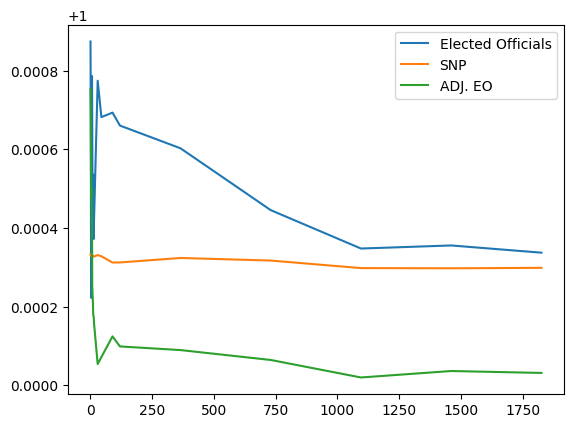

In [ ]:
plt.plot(timeframes,EO_perf)
plt.plot(timeframes,SNP_perf)
plt.plot(timeframes,EO_perf_adj)

plt.legend(["Elected Officials", "SNP", "ADJ. EO"])
plt.show()

In [ ]:
temp_data = data
print(len(data))
data = data[data['change_over_13_days']!=-1]
data = data[data['change_over_13_days'].isna()==False]
data = data[data['S&P_change_over_13_days'].isna()==False]
print(len(data))
print(len(data[data['change_over_13_days']/data['S&P_change_over_13_days']>=1])/len(data))
print(np.nanmean(data['change_over_13_days']/data['S&P_change_over_13_days']))
data=temp_data

23840
19717
0.4984023938733073
0.9983062970748345


In [ ]:
searchDataByName('Booker', data)

,transaction_date,disclosure_date,owner,ticker,asset_description,asset_type,type,amount,comment,ptr_link,...,change_over_365_days,S&P_change_over_365_days,change_over_730_days,S&P_change_over_730_days,change_over_1095_days,S&P_change_over_1095_days,change_over_1460_days,S&P_change_over_1460_days,change_over_1825_days,S&P_change_over_1825_days
7541,2014-08-08,2014-09-07,Self,NKE,"Nike, Inc. (NYSE)",NaN,Sale (Full),"$1,001 - $15,000",--,https://efdsearch.senate.gov/search/view/ptr/7...,...,1.541311,1.089351,1.511591,1.129065,1.639905,1.284387,2.236664,1.479843,2.281946,1.493060
7542,2014-08-08,2014-09-07,Self,IRM,Iron Mountain Inc. (NYSE),NaN,Sale (Full),"$1,001 - $15,000",--,https://efdsearch.senate.gov/search/view/ptr/7...,...,1.006204,1.089351,1.357140,1.129065,1.455320,1.284387,1.502341,1.479843,1.384367,1.493060
7543,2014-08-08,2014-09-07,Self,IBM,International Business Machines Corporation (N...,NaN,Sale (Full),"$1,001 - $15,000",--,https://efdsearch.senate.gov/search/view/ptr/7...,...,0.873313,1.089351,0.948539,1.129065,0.863561,1.284387,0.923935,1.479843,0.918155,1.493060
7544,2014-08-08,2014-09-07,Self,FB,"Facebook, Inc. (NASDAQ)",NaN,Sale (Full),"$1,001 - $15,000",--,https://efdsearch.senate.gov/search/view/ptr/7...,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
7545,2014-08-08,2014-09-07,Self,AMZN,Amazon.com Inc. (NASDAQ),NaN,Sale (Full),"$1,001 - $15,000",--,https://efdsearch.senate.gov/search/view/ptr/7...,...,1.654040,1.089351,2.419697,1.129065,3.132165,1.284387,5.879040,1.479843,5.660985,1.493060
7546,2014-08-08,2014-09-07,Self,AAPL,Apple Inc. (NASDAQ),NaN,Sale (Full),"$1,001 - $15,000",--,https://efdsearch.senate.gov/search/view/ptr/7...,...,1.285271,1.089351,1.188296,1.129065,1.765166,1.284387,2.337802,1.479843,2.280910,1.493060
7547,2014-08-08,2014-09-07,Self,DISH,Dish Network Corp. (NASDAQ),NaN,Sale (Full),"$1,001 - $15,000",--,https://efdsearch.senate.gov/search/view/ptr/7...,...,1.074281,1.089351,0.819329,1.129065,0.959105,1.284387,0.586422,1.479843,0.503355,1.493060
7548,2014-08-08,2014-09-07,Self,AMT,American Tower Corporation (NYSE),NaN,Sale (Full),"$50,001 - $100,000",--,https://efdsearch.senate.gov/search/view/ptr/7...,...,1.041453,1.089351,1.223806,1.129065,1.490074,1.284387,1.653038,1.479843,2.443757,1.493060
7549,2014-08-08,2014-09-07,Self,EBAY,eBay Inc. (NASDAQ),NaN,Sale (Full),"$1,001 - $15,000",--,https://efdsearch.senate.gov/search/view/ptr/7...,...,1.258942,1.089351,1.368319,1.129065,1.586197,1.284387,1.483847,1.479843,1.758115,1.493060
7550,2014-08-08,2014-09-07,Self,IRM,Iron Mountain Inc. (NYSE),NaN,Sale (Full),"$1,001 - $15,000",--,https://efdsearch.senate.gov/search/view/ptr/7...,...,1.006204,1.089351,1.357140,1.129065,1.455320,1.284387,1.502341,1.479843,1.384367,1.493060


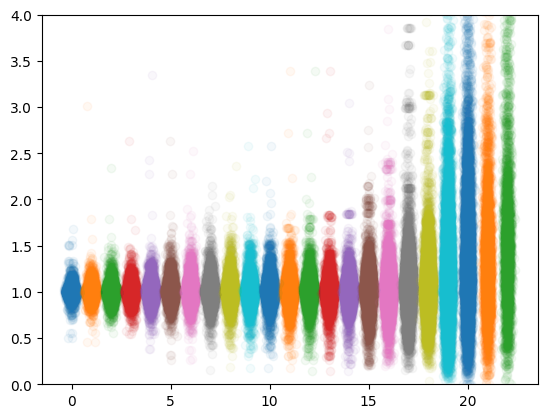

In [ ]:

for t in range(len(timeframes[:-1])):
    plt.scatter(np.zeros(len(data))+t+np.random.normal(0, .1, len(data)),data['change_over_'+str(timeframes[t])+'_days'], alpha=.05)

plt.ylim(0, 4)
plt.show()


In [ ]:
data_inside = data[data['last_name'] in committee_assignments.index]
data_inside['committee'] == np.empty((len(data_inside), 0)).tolist()
for d in data_inside:
    data_inside['committee'] = getCommitteesByName(committee_assignments, d['last_name'], min_year=2005, max_year=2023)